# Project 4 - Choose Your Own Adventure: Reddit Posts (from Richard)

#### Name: Maria Yarolin

#### Due Date: November 29, 2017

---

#### Project Instructions from Instructor

I've provided a collection of posts from reddit.com from numerous programming-focused subreddits. Your task is...to give us a model!

As Data Scientists, it is very frequently up to us to find interesting questions and useful inferences from a body of data. Similar to our expectations for your Capstone Project, this is a situation where you will manage both the development of a question and your approach for modelling it.

Within this directory you will find a csv containing all posts made to a specific set of subreddits (message boards) during the month of December, along with some additional data (the number of upvotes from the community, the number of comments made on the post, etc.) While reddit allows you to submit a link in place of text, this data has been subset to only self-posts (posts where the writer has submitted text instead of a link elsewhere).

---

In [31]:
# imports

from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import StandardScaler

import string

In [2]:
# Load dataset
reddit_posts = pd.read_csv('reddit_posts.csv', na_values='?')

## Exploratory Data Analysis

In [3]:
# view dataset
reddit_posts.head()

,adserver_click_url,adserver_imp_pixel,archived,author,author_flair_css_class,author_flair_text,contest_mode,created_utc,disable_comments,distinguished,...,spoiler,stickied,subreddit,subreddit_id,third_party_tracking,third_party_tracking_2,thumbnail,title,ups,url
0,NaN,NaN,False,johnnyawesome0,NaN,NaN,False,1480697304,NaN,NaN,...,False,False,techsupport,t5_2qioo,NaN,NaN,self,Help with audio set-up,1.0,https://www.reddit.com/r/techsupport/comments/...
1,NaN,NaN,False,Silverfin113,NaN,NaN,False,1480697424,NaN,NaN,...,False,False,learnprogramming,t5_2r7yd,NaN,NaN,self,Optimizing code for speed,23.0,https://www.reddit.com/r/learnprogramming/comm...
2,NaN,NaN,False,bookbooksbooks,NaN,NaN,False,1480697613,NaN,NaN,...,False,False,gamedev,t5_2qi0a,NaN,NaN,self,Seeking Tales of Development Woe (and Triumph)...,12.0,https://www.reddit.com/r/gamedev/comments/5g4a...
3,NaN,NaN,False,[deleted],NaN,NaN,False,1480697634,NaN,NaN,...,False,False,learnprogramming,t5_2r7yd,NaN,NaN,default,[Java] Finding smallest value in an array,0.0,https://www.reddit.com/r/learnprogramming/comm...
4,NaN,NaN,False,caffeine_potent,NaN,NaN,False,1480697748,NaN,NaN,...,False,False,learnpython,t5_2r8ot,NaN,NaN,self,currying functions using functools,6.0,https://www.reddit.com/r/learnpython/comments/...


In [4]:
reddit_posts.shape
# total 26,688 rows, 53 columns

(26688, 53)

In [5]:
# View list of all column names
reddit_posts.columns

Index(['adserver_click_url', 'adserver_imp_pixel', 'archived', 'author',
       'author_flair_css_class', 'author_flair_text', 'contest_mode',
       'created_utc', 'disable_comments', 'distinguished', 'domain', 'downs',
       'edited', 'gilded', 'hide_score', 'href_url', 'id', 'imp_pixel',
       'is_self', 'link_flair_css_class', 'link_flair_text', 'locked', 'media',
       'media_embed', 'mobile_ad_url', 'name', 'num_comments', 'original_link',
       'over_18', 'permalink', 'post_hint', 'preview', 'promoted',
       'promoted_by', 'promoted_display_name', 'promoted_url', 'quarantine',
       'retrieved_on', 'saved', 'score', 'secure_media', 'secure_media_embed',
       'selftext', 'spoiler', 'stickied', 'subreddit', 'subreddit_id',
       'third_party_tracking', 'third_party_tracking_2', 'thumbnail', 'title',
       'ups', 'url'],
      dtype='object')

In [6]:
# View head of all 53 columns, for insight on their content
with pd.option_context('display.max_rows', 5, 'display.max_columns', 53):
    print(reddit_posts.head())

   adserver_click_url  adserver_imp_pixel  archived           author  \
0                 NaN                 NaN     False   johnnyawesome0   
1                 NaN                 NaN     False     Silverfin113   
2                 NaN                 NaN     False   bookbooksbooks   
3                 NaN                 NaN     False        [deleted]   
4                 NaN                 NaN     False  caffeine_potent   

  author_flair_css_class author_flair_text  contest_mode  created_utc  \
0                    NaN               NaN         False   1480697304   
1                    NaN               NaN         False   1480697424   
2                    NaN               NaN         False   1480697613   
3                    NaN               NaN         False   1480697634   
4                    NaN               NaN         False   1480697748   

   disable_comments distinguished                 domain  downs      edited  \
0               NaN           NaN       self.tech

In [7]:
# Get information about the columns
reddit_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26688 entries, 0 to 26687
Data columns (total 53 columns):
adserver_click_url        0 non-null float64
adserver_imp_pixel        0 non-null float64
archived                  26688 non-null bool
author                    26688 non-null object
author_flair_css_class    435 non-null object
author_flair_text         351 non-null object
contest_mode              26688 non-null bool
created_utc               26688 non-null int64
disable_comments          0 non-null float64
distinguished             85 non-null object
domain                    26688 non-null object
downs                     26688 non-null float64
edited                    26688 non-null object
gilded                    26688 non-null float64
hide_score                26688 non-null bool
href_url                  0 non-null float64
id                        26688 non-null object
imp_pixel                 0 non-null float64
is_self                   26688 non-null bool
link_fla

The number of columns from each data type: bool(10), float64(19), int64(1), object(23)

There are several columns with all/most values as null - there are too many empty values to impute without potentially altering the data. We will ignore those, and they will not be used in modeling.

In [8]:
# examine contents of columns to see what may be useful in modeling
reddit_posts['stickied'].value_counts()

False    26687
True         1
Name: stickied, dtype: int64

#### Selection of columns to retain/drop
Many columns I decided to drop because they were either empty (e.g., *disable_comments*), lacked variation (e.g., *hide_score, stickied*), or contained data I considered to be non-useful for analysis purposes (e.g., *url*). 

Of the rest, these have potential for analysis:
- *edited*:       26688 non-null object  [False 23172, others numeric text (indicating a date?)]
- *is_self*:      26688 non-null bool    [True 24594, False 2094 (self-posts don't link outside of reddit)]
- *num_comments*: 26688 non-null float64 [number of comments]
- *score*:        26688 non-null float64 [score - number of upvotes minus the number of downvotes]
- *selftext*:     26688 non-null object  [text of postings - use as predictor]
- *subreddit*:    26688 non-null object  [sub-communities, each focused on a specific topic (38 total)]
- *thumbnail*:    26688 non-null object  [self 18192, default 8480, nsfw 16]
- *title*:        26688 non-null object  [title of postings - use as predictor]
- *ups*:          26688 non-null float64 [upvotes. note, each had 0 downvotes, so *score* = *ups* here and this column is redundant]

#### Final set of columns to retain, and their roles:

Variables to use for **text analysis**: *selftext, title*

Variables to potentially use for **classification**: *edited, is_self, subreddit, thumbnail*

Variables to potentially use for **regression**: *num_comments, score*

---

## Preprocessing

#### Create dataframes containing only the working variables

In [9]:
# Create dataframe with subset of columns to be used for modeling
df_modeling = reddit_posts[['edited', 'is_self', 'subreddit', 'thumbnail', 'num_comments', 'score','selftext', 
                          'title']].copy()
df_modeling.head()

,edited,is_self,subreddit,thumbnail,num_comments,score,selftext,title
0,False,True,techsupport,self,1.0,1.0,I have a Sony surround sound system for a blu-...,Help with audio set-up
1,False,True,learnprogramming,self,8.0,23.0,I've written what seems to be a prohibitively ...,Optimizing code for speed
2,False,True,gamedev,self,5.0,12.0,"I'm writing an article called ""Video Games Tha...",Seeking Tales of Development Woe (and Triumph)...
3,1480698462,True,learnprogramming,default,9.0,0.0,[deleted],[Java] Finding smallest value in an array
4,1480709138,True,learnpython,self,12.0,6.0,I have the following representation of argumen...,currying functions using functools


In [10]:
# Dummify the edited column in the classification dataframe
df_modeling['edited'] = df_modeling['edited'].apply(lambda x: 0 if x == 'False' else 1)
df_modeling.head()

,edited,is_self,subreddit,thumbnail,num_comments,score,selftext,title
0,0,True,techsupport,self,1.0,1.0,I have a Sony surround sound system for a blu-...,Help with audio set-up
1,0,True,learnprogramming,self,8.0,23.0,I've written what seems to be a prohibitively ...,Optimizing code for speed
2,0,True,gamedev,self,5.0,12.0,"I'm writing an article called ""Video Games Tha...",Seeking Tales of Development Woe (and Triumph)...
3,1,True,learnprogramming,default,9.0,0.0,[deleted],[Java] Finding smallest value in an array
4,1,True,learnpython,self,12.0,6.0,I have the following representation of argumen...,currying functions using functools


In [11]:
# Dummify the is_self column in the modeling dataframe
df_modeling['is_self'] = df_modeling['is_self'].astype(str)
df_modeling['is_self'] = df_modeling['is_self'].apply(lambda x: 1 if x == 'True' else 0)
df_modeling.head()

,edited,is_self,subreddit,thumbnail,num_comments,score,selftext,title
0,0,1,techsupport,self,1.0,1.0,I have a Sony surround sound system for a blu-...,Help with audio set-up
1,0,1,learnprogramming,self,8.0,23.0,I've written what seems to be a prohibitively ...,Optimizing code for speed
2,0,1,gamedev,self,5.0,12.0,"I'm writing an article called ""Video Games Tha...",Seeking Tales of Development Woe (and Triumph)...
3,1,1,learnprogramming,default,9.0,0.0,[deleted],[Java] Finding smallest value in an array
4,1,1,learnpython,self,12.0,6.0,I have the following representation of argumen...,currying functions using functools


In [12]:
# Dummify the subreddit and thumbnail columns in the modeling dataframe
df_modeling = pd.get_dummies(df_modeling, columns=['subreddit', 'thumbnail'])
df_modeling.head()

,edited,is_self,num_comments,score,selftext,title,subreddit_HTML,subreddit_IPython,subreddit_PHP,subreddit_Python,...,subreddit_pystats,subreddit_pythoncoding,subreddit_ruby,subreddit_swift,subreddit_technology,subreddit_techsupport,subreddit_web_design,thumbnail_default,thumbnail_nsfw,thumbnail_self
0,0,1,1.0,1.0,I have a Sony surround sound system for a blu-...,Help with audio set-up,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,1,8.0,23.0,I've written what seems to be a prohibitively ...,Optimizing code for speed,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,5.0,12.0,"I'm writing an article called ""Video Games Tha...",Seeking Tales of Development Woe (and Triumph)...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,9.0,0.0,[deleted],[Java] Finding smallest value in an array,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,1,12.0,6.0,I have the following representation of argumen...,currying functions using functools,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
# Get current column names from the modeling dataframe
df_modeling.columns

Index(['edited', 'is_self', 'num_comments', 'score', 'selftext', 'title',
       'subreddit_HTML', 'subreddit_IPython', 'subreddit_PHP',
       'subreddit_Python', 'subreddit_coding', 'subreddit_compsci',
       'subreddit_computerscience', 'subreddit_cpp', 'subreddit_css',
       'subreddit_csshelp', 'subreddit_dailyprogrammer', 'subreddit_django',
       'subreddit_engineering', 'subreddit_flask', 'subreddit_gamedev',
       'subreddit_html5', 'subreddit_iOSProgramming',
       'subreddit_inventwithpython', 'subreddit_java', 'subreddit_javahelp',
       'subreddit_javascript', 'subreddit_jquery',
       'subreddit_learnprogramming', 'subreddit_learnpython',
       'subreddit_linux', 'subreddit_lisp', 'subreddit_netsec',
       'subreddit_perl', 'subreddit_programmer', 'subreddit_programming',
       'subreddit_pygame', 'subreddit_pystats', 'subreddit_pythoncoding',
       'subreddit_ruby', 'subreddit_swift', 'subreddit_technology',
       'subreddit_techsupport', 'subreddit_web_desig

#### Explore text and heading columns for insight on further processing

In [14]:
# Subset the selftext column for further exploration
selftext = reddit_posts['selftext']
selftext.head()

0    I have a Sony surround sound system for a blu-...
1    I've written what seems to be a prohibitively ...
2    I'm writing an article called "Video Games Tha...
3                                            [deleted]
4    I have the following representation of argumen...
Name: selftext, dtype: object

In [15]:
# Subset the title column for further exploration
title = reddit_posts['title']
title.head()

0                               Help with audio set-up
1                            Optimizing code for speed
2    Seeking Tales of Development Woe (and Triumph)...
3            [Java] Finding smallest value in an array
4                   currying functions using functools
Name: title, dtype: object

In [16]:
# Run an initial CountVectorizer with default settings on the selftext column to see what's there
cv = CountVectorizer()
cv.fit(selftext)
cv.transform(selftext)

<26688x61622 sparse matrix of type '<class 'numpy.int64'>'
	with 1434003 stored elements in Compressed Sparse Row format>

In [17]:
cv.transform(selftext).todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [18]:
df_selftext = pd.DataFrame(cv.transform(selftext).todense(), columns=cv.get_feature_names())
df_selftext.head()

,00,000,0000,00000,000000,0000000,00000000,000000000000,0000000000000000,0000000000000001,...,최근,추가,포함한,해외,협력,협력병원리스트,협력병원은,회원은,𝛿1,𝛿3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Examine the top 10 occurring words
print(df_selftext.sum().sort_values(ascending=False).head(10))

the     91776
to      69123
and     54272
it      43531
is      30794
my      30439
of      27158
in      25519
that    23045
for     22286
dtype: int64


#### Initial observations on the data in the *selftext* column, after the first CountVectorizer pass:
The top 10 words are common and non-subject-specific words which appear in the stopwords list. There are also 
61,622 columns. We need to rerun CountVectorizer and add some arguments to whittle down the list.

In [20]:
# Rerun CountVectorizer to exclude stopwords, allow 2-word pairs, and limit the number of columns to 100
cv = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=100)
cv.fit(selftext)
cv.transform(selftext)

cv.transform(selftext).todense()
df_selftext = pd.DataFrame(cv.transform(selftext).todense(), 
             columns=cv.get_feature_names())
df_selftext.head()

,10,able,amp,bit,boot,card,class,code,com,computer,...,ve,video,want,way,windows,windows 10,work,working,works,www
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,2,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [21]:
# Examine the top 10 occuring words in this round of CountVectorizer
print(df_selftext.sum().sort_values(ascending=False).head(10))

just        8487
windows     8088
com         7557
like        7466
ve          7185
gt          6186
deleted     5475
help        5266
computer    5254
time        5195
dtype: int64


In [22]:
# View the heading names of all 100 columns
df_selftext.columns

Index(['10', 'able', 'amp', 'bit', 'boot', 'card', 'class', 'code', 'com',
       'computer', 'cpu', 'data', 'deleted', 'did', 'different', 'does',
       'doesn', 'doing', 'don', 'drive', 'drivers', 'edit', 'error', 'file',
       'files', 'fine', 'fix', 'game', 'games', 'getting', 'going', 'good',
       'got', 'gpu', 'gt', 'hard', 'having', 'help', 'hi', 'http', 'https',
       'imgur', 'imgur com', 'install', 'int', 'internet', 'issue', 'just',
       'know', 'laptop', 'like', 'list', 'looking', 'lt', 'make', 'monitor',
       'motherboard', 'need', 'new', 'old', 'pc', 'power', 'print', 'problem',
       'program', 'python', 'ram', 'really', 'removed', 'right', 'run',
       'running', 'screen', 'set', 'ssd', 'start', 'started', 'sure', 'thanks',
       'thing', 'things', 'think', 'time', 'tried', 'try', 'trying', 'usb',
       'use', 'used', 'using', 've', 'video', 'want', 'way', 'windows',
       'windows 10', 'work', 'working', 'works', 'www'],
      dtype='object')

#### Additional observations on the *selftext* column, after the second CountVectorizer pass:
Some words share the same stem and can be combined in the next round of CountVectorize: file/files, game/games, http/https, imgur/imgur com, run/running, start/started, thing/things, tried/try/trying, use/used/using, windows/windows 10, work/working/works.

In [32]:
# Define a preprocessor function to clean the text by grouping into stems, excluding stopwords, removing 
# punctuation, removing digits, and removing spaces.

def cleaner(text):
    stemmer = PorterStemmer()                                          # groups words having the same stems
    stop = stopwords.words('english')                                  # excludes stop words
    text = text.translate(str.maketrans('', '', string.punctuation))   # removes punctuation
    text = text.translate(str.maketrans('', '', string.digits))        # removes digits
    text = text.lower().strip()                                        # removes spaces
    final_text = []
    for w in text.split():
        if w not in stop:
            final_text.append(stemmer.stem(w.strip()))
    return ' '.join(final_text)

In [33]:
# Run a final CountVectorizer on selftext to include the cleaning preprocessor arguments
cv = CountVectorizer(preprocessor=cleaner, ngram_range=(1,2), max_features=100)
cv.fit(selftext)
cv.transform(selftext)

cv.transform(selftext).todense()
df_selftext = pd.DataFrame(cv.transform(selftext).todense(), 
             columns=cv.get_feature_names())
df_selftext.head()

,also,anyon,anyth,appreci,back,boot,cant,card,chang,class,...,tri,turn,updat,use,video,want,way,window,work,would
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,2,0,0,0,...,0,0,0,1,1,0,0,0,2,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,3,0,0,1,0,0,0,0,1,0


In [34]:
# Examine the top 10 occuring words in this round of CountVectorizer
print(df_selftext.sum().sort_values(ascending=False).head(10))

use       12130
im        11982
tri       10260
work       9556
get        8457
window     8196
would      7729
like       7686
ive        7085
game       6510
dtype: int64


In [35]:
# View the heading names of all 100 columns
df_selftext.columns

Index(['also', 'anyon', 'anyth', 'appreci', 'back', 'boot', 'cant', 'card',
       'chang', 'class', 'code', 'comput', 'connect', 'could', 'cpu', 'creat',
       'current', 'data', 'delet', 'devic', 'differ', 'doesnt', 'dont',
       'drive', 'driver', 'edit', 'error', 'even', 'everyth', 'file', 'find',
       'fine', 'first', 'fix', 'function', 'game', 'gb', 'get', 'go', 'got',
       'gt', 'happen', 'help', 'idea', 'im', 'instal', 'issu', 'ive', 'know',
       'laptop', 'learn', 'like', 'look', 'make', 'monitor', 'much', 'need',
       'new', 'noth', 'one', 'pc', 'play', 'power', 'problem', 'program',
       'python', 'question', 'ram', 'realli', 'remov', 'return', 'right',
       'run', 'say', 'screen', 'see', 'seem', 'set', 'show', 'sinc', 'someth',
       'start', 'still', 'sure', 'system', 'take', 'thank', 'thing', 'think',
       'time', 'tri', 'turn', 'updat', 'use', 'video', 'want', 'way', 'window',
       'work', 'would'],
      dtype='object')

The final iteration of CountVectorizer does the following:
- group text by root word stems
- exclude stopwords
- remove punctuation
- remove digits
- remove spaces
- allow the consideration of 2-word groupings
- limit the number of features produced to 100.

---

## Modeling

### Classification

In [36]:
# Train-test split, using is_self variable as target and selftext as predictor
X_train, X_test, y_train, y_test = train_test_split(df_modeling['selftext'].values,
                                                   df_modeling['is_self'].values,
                                                   test_size=0.30, random_state=42)
print('X_train ', X_train.shape, '\n', 'X_test ', X_test.shape, '\n', 'y_train ', y_train.shape, '\n', 
      'y_test', y_test.shape)

X_train  (18681,) 
 X_test  (8007,) 
 y_train  (18681,) 
 y_test (8007,)


There are 18,681 cases in the training set and 8007 cases in the testing set.

In [80]:
# Run CountVectorizer on the X train/test (selftext) using the arguments identified earlier
cv = CountVectorizer(preprocessor=cleaner, ngram_range=(1,2), max_features=100)
cv.fit(X_train)
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)
print('X_train_cv ', X_train_cv.shape, '\n', 'X_test_cv ', X_test_cv.shape)

X_train_cv  (18681, 100) 
 X_test_cv  (8007, 100)


In [81]:
# Determine baseline
baseline = y_train.mean()
baseline

0.92264868047749049

The baseline is 0.923

In [82]:
# Fit and score a KNeighborsClassifier using 5 neighbors
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train_cv, y_train)

# predictions and pred prob.
yhat = knn5.predict(X_test_cv)
yhat_pp = knn5.predict_proba(X_test_cv)

print('Accuracy: ', metrics.accuracy_score(y_test, yhat))

Accuracy:  0.877981765955


The accuracy is 0.877, lower than the baseline of 0.923.

In [83]:
# Manually calculate the true positives, false positives, true negatives, and false negatives.
tp = np.sum((y_test == 1) & (yhat == 1))
fp = np.sum((y_test == 0) & (yhat == 1))
tn = np.sum((y_test == 0) & (yhat == 0))
fn = np.sum((y_test == 1) & (yhat == 0))
print(tp, fp, tn, fn)

6381 0 649 977


In [84]:
# Construct the confusion matrix
conmat = np.array(confusion_matrix(y_test, yhat, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['self', 'not self'],
                         columns=['predicted self','predicted not self'])
confusion

,predicted self,predicted not self
self,6381,977
not self,0,649


Of the 8007 test cases, 7338 were accurately predicted to be 'self' (true positives), while 0 cases were accurately predicted to be 'not self' (true negatives). Conversely, 643 'not self' cases were inaccurately predicted as 'self' (false positives), and 26 'self' cases were predicted as 'not self' (false negatives).

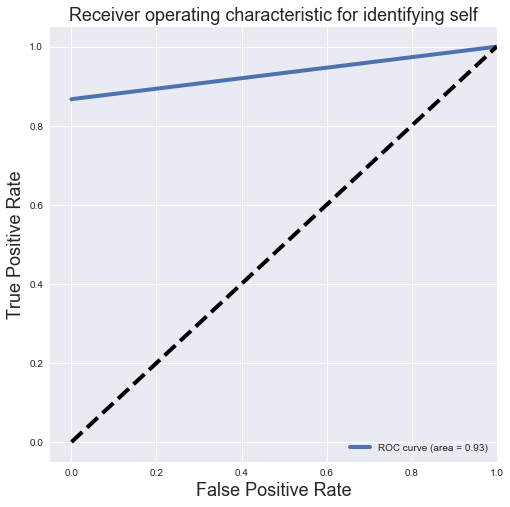

In [86]:
# Plot a ROC Curve and find the area under the curve for class 1 (is_self = True)
fpr, tpr, thresh = roc_curve(y_test, yhat_pp[:,1])  # fpr: false positive rate, tpr: true positive rate
roc_auc = auc(fpr, tpr)  # calculates area under the curve

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for identifying self', fontsize=18)
plt.legend(loc="lower right")
plt.show()

The ROC curve visualizes the performance of a classifier by comparing the true positive rate to the false positive rate as the threshold for prediction changes. When the area under the curve is 0.50, this is equal to the baseline (chance) prediction. When the area under the curve is 1.00, this is equal to a perfect prediction.

Here, the area under the curve is 0.93, incidating not perfect performance, but still slightly better than the baseline of 0.923.